# Machine Learning 521 Final Report
## Predicting Quarterly Earnings per Share with Time Series Data
#### RNN by Franco Rey
#### Gradient Boosted Regressor Trees by Hank Beck
#### Random Forest Regression by Bhavesh
#### Kmean Regime Clustering and Markov Chain by Kevin

# Introduction
    - What are traditional methods for forecasting returns?
    - What is the benefit of machine learning to this problem
    - What models did we choose to explore
    - What is the goal of your project?
• What is the data that you are using? What is the original data source if known?
• What does an instance in your data represent (e.g. a person, a transaction, etc.)? How many
instances are there?
• What is the target variable you are trying to predict?
• What are the features used to predict it? Give a few examples of the features.
• Provide any additional relevant information about your data if known (e.g. what is the time
period, what place is it collected from, etc.)



# Data

## Target
    - Reported EPS
    
## Features
    
## Data Sources
    - Yahoo finance
    - Alpha Vantage
    
## Things that needed to be accounted for
    - look ahead bias
    - Information available when predictions are to be made
    - Stationarity 
    - survivorship Bias
    
## Pros of the data set

## Cons of dataset

## Ways the dataset could be theorectically improved if more data available
    - longer time period
        

# Data Fetching and Cleaning
I will work here before merging with main so we have a backup in case someone messes up a merge with their independent branch

In [178]:
# import modules
import pandas as pd
import pandas_datareader as pdr
import csv
# system related
import warnings
import os
from dotenv import load_dotenv
# math
import numpy as np
from scipy.stats import gmean
# Modules for fetching data
import yfinance as yf
import requests

In [179]:
# Suppress specific pandas warnings
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None  # default='warn'

load_dotenv()
AV_api_key = os.getenv("ALPHA_VANTAGE_API_KEY")

## Fetching Initial Data

### Sourced from yahoo

In [180]:
START_DATE_yahoo ="1990-01-01"
END_DATE_yahoo = "2024-05-30"

# Larger Market trends 

# S&P 500
sp500_ticker = '^GSPC'
sp500_csv = '.\data_files\sp500_RawData.csv'
START_DATE_sp500 = START_DATE_yahoo
END_DATE_sp500 = END_DATE_yahoo

# CBOE Volatility Index (VIX)
vix_ticker = '^VIX'
vix_csv = '.\data_files\VIX_RawData.csv'
START_DATE_vix = START_DATE_yahoo
END_DATE_vix = END_DATE_yahoo

# Large Cap Stocks

# Microsoft (MSFT)
micro_ticker = 'MSFT'
micro_csv = '.\data_files\MSFT_RawData.csv'
micro_earnings_csv = '.\data_files\MSFTquarterlyEarnings.csv'
micro_balSht_csv = '.\data_files\MSFTquarterlyBalSheet.csv'
START_DATE_msft = START_DATE_yahoo
END_DATE_msft = END_DATE_yahoo

# General Electric (GE)
general_elec_ticker = 'GE'
ge_csv = '.\data_files\GE_RawData.csv'
START_DATE_ge = START_DATE_yahoo
END_DATE_ge = END_DATE_yahoo

# Johnson and Johnson (JNJ)
jj_ticker = 'JNJ'
jj_csv = '.\data_files\JNJ_RawData.csv'
jj_earnings_csv = '.\data_files\JNJquarterlyEarnings.csv'
jj_balSht_csv = '.\data_files\JNJquarterlyBalSheet.csv'
jj_dividend_csv = '.\data_files\JNJdividends.csv'
START_DATE_jj = START_DATE_yahoo
END_DATE_jj = END_DATE_yahoo

# Coca Cola (KO)
cc_ticker = 'KO'
cc_csv = '.\data_files\KO_RawData.csv'
START_DATE_cc = START_DATE_yahoo
END_DATE_cc = END_DATE_yahoo


# FROM CSVs Create Collated Data Frame

Features to Extract:

    - reported Earnings Per Share
    - Total Assets
    - Accruals 
    - Equity Ratio 
    - Cash Dividends Paid Since last Quarter
    - VIX Lagged By By several steps out
        - Can achieve some granularity this way despite looking to make quarterly predictions for earnings
    - S&P Lagged for several steps 
        - Can provide information on how it has moved over the last several weeks not just quarter to quarter snapshots 

In [181]:
Market_Features_to_drop = ['Volume','High','Low','Adj Close']
Balance_sheet_features_to_keep = ['totalAssets','totalShareholderEquity']

# Get Price Data
SP500_raw_df = pd.read_csv(sp500_csv, index_col = 'Date')
VIX_raw_df = pd.read_csv(vix_csv, index_col = 'Date')
JJ_raw_price_df = pd.read_csv(jj_csv, index_col = 'Date')

# Get Quarterly Data
JJ_Earnings_df = pd.read_csv(jj_earnings_csv)
JJ_Earnings_df['Date'] = pd.to_datetime(JJ_Earnings_df['Fiscal Date'])
JJ_Earnings_df.drop(columns = ['Fiscal Date'], inplace = True)
JJ_Earnings_df.set_index('Date', inplace = True)
JJ_Earnings_df =  JJ_Earnings_df.iloc[::-1]

JJ_BalSht_df = pd.read_csv(jj_balSht_csv)
JJ_BalSht_df['Date'] = pd.to_datetime(JJ_BalSht_df['fiscalDateEnding'])
JJ_BalSht_df.drop(columns = ['fiscalDateEnding'], inplace = True)
JJ_BalSht_df.set_index('Date', inplace = True)
JJ_BalSht_df =  JJ_BalSht_df.iloc[::-1]

# get Dividend Data
JJ_dividend_df = pd.read_csv(jj_dividend_csv)
JJ_dividend_df['Date'] = JJ_dividend_df['Date'].str.split().str[0]
JJ_dividend_df.set_index('Date', inplace = True)

# drop market feature form S&P and VIX
SP500_raw_df.drop(columns= Market_Features_to_drop, inplace= True)
VIX_raw_df.drop(columns=Market_Features_to_drop, inplace= True)

# drop high and low
JJ_raw_price_df.drop(columns=['High','Adj Close', 'Low'], inplace=True)

# Calculate daily return
SP500_raw_df['Daily_Return_dollars'] = SP500_raw_df['Close'] - SP500_raw_df['Open']
VIX_raw_df['Daily_Return_dollars'] = VIX_raw_df['Close'] - VIX_raw_df['Open']

SP500_raw_df['Daily_Return_percent'] = SP500_raw_df['Daily_Return_dollars']/SP500_raw_df['Open']
VIX_raw_df['Daily_Return_percent'] = VIX_raw_df['Daily_Return_dollars']/VIX_raw_df['Open']

JJ_raw_price_df['Daily_Return_dollars'] = JJ_raw_price_df['Close'] - JJ_raw_price_df['Open']
JJ_raw_price_df['Daily_Return_percent'] = JJ_raw_price_df['Daily_Return_dollars']/JJ_raw_price_df['Open']

# drop open and close
JJ_raw_price_df.drop(columns=['Open','Close','Daily_Return_dollars'], inplace = True)
SP500_raw_df.drop(columns=['Open','Close','Daily_Return_dollars'], inplace = True)
VIX_raw_df.drop(columns=['Open','Close','Daily_Return_dollars'], inplace = True)

# Balance Sheet Features
JJ_Bal_Sheet_reduced_df = JJ_BalSht_df.loc[:,Balance_sheet_features_to_keep]
JJ_Bal_Sheet_reduced_df['Equity Ratio'] = JJ_Bal_Sheet_reduced_df['totalShareholderEquity'] /JJ_Bal_Sheet_reduced_df['totalAssets']
JJ_Bal_Sheet_reduced_df.drop(columns=['totalShareholderEquity'], inplace = True)


# JJ merge
JJ_market_df = JJ_dividend_df.merge(JJ_raw_price_df, how = 'outer', left_index=True, right_index=True)
JJ_market_df.index = pd.to_datetime(JJ_market_df.index)
JJ_market_df = JJ_market_df['1995':]

JJ_earnbal_df = JJ_Earnings_df.merge(JJ_Bal_Sheet_reduced_df, how = 'outer', left_index = True, right_index = True)
JJ_merge_df = JJ_market_df.merge(JJ_earnbal_df,how = 'outer', left_index= True, right_index= True)

# Merge Raw Data
market_df = SP500_raw_df.merge(VIX_raw_df, left_index=True, right_index=True,suffixes=('_SP','_VIX'))
market_df.index = pd.to_datetime(market_df.index)

# drop prior to the start of 1995 So we have data for lagged features
market_df = market_df['1995':]

merged_df = market_df.merge(JJ_merge_df, how = 'outer', left_index= True, right_index= True)

merged_df.sort_index(inplace=True)
                            
# Display Data Frame Head
#merged_df.head()

# Create features for avergage daily returns for the prior quarter
monthly_return_feats = ['Daily_Return_percent_SP','Daily_Return_percent_VIX','Daily_Return_percent']


for feat in monthly_return_feats:
    # Create a column to store the geometric mean
    new_week_feat_name = 'geo_mean_' + feat + '_prev_week'
    new_month_feat_name = 'geo_mean_' + feat + '_prev_month'
    new_quarter_feat_name = 'geo_mean_' + feat + '_prev_quarter'
    merged_df[new_week_feat_name] = np.nan
    merged_df[new_month_feat_name] = np.nan
    merged_df[new_quarter_feat_name] = np.nan
    # Iterate over rows where 'target' is not NaN
    for idx, row in merged_df[merged_df['Estimated EPS'].notna()].iterrows():
        # Identify the week ending at the current row's index
        end_date = idx
        start_date_week  = end_date - pd.Timedelta(days=7)
        start_date_month = end_date - pd.Timedelta(weeks=4)
        start_date_quarter = end_date - pd.Timedelta(weeks=12)
        # Get the week prior data
        prior_week_data = merged_df.loc[start_date_week:end_date][feat]
        prior_week_data.dropna(inplace= True)
        # month
        prior_month_data = merged_df.loc[start_date_month:end_date][feat]
        prior_month_data.dropna(inplace= True)
        # quarter
        prior_quarter_data = merged_df.loc[start_date_quarter:end_date][feat]
        prior_quarter_data.dropna(inplace= True)
        if feat == 'Daily_Return_percent_SP':
            check_df = prior_week_data
        # Calculate the geometric mean
        if len(prior_week_data) > 0:
            geo_mean = gmean(1+prior_week_data)
            merged_df.at[idx, new_week_feat_name] = (geo_mean - 1)
        if len(prior_month_data) > 0:
            geo_mean = gmean(1+prior_month_data)
            merged_df.at[idx, new_month_feat_name] = (geo_mean - 1)
        if len(prior_quarter_data) > 0:
            geo_mean = gmean(1+prior_quarter_data)
            merged_df.at[idx, new_quarter_feat_name] = (geo_mean - 1)
    merged_df.drop(columns = feat, inplace=True)


# Create avergage daily volume
new_feat_name = 'geo_mean_volume_prev_quarter'
merged_df[new_feat_name] = np.nan
# Iterate over rows where 'target' is not NaN
for idx, row in merged_df[merged_df['Estimated EPS'].notna()].iterrows():
    # Identify the week ending at the current row's index
    end_date = idx
    #start_date_week  = end_date - pd.Timedelta(days=7)
    #start_date_month = end_date - pd.Timedelta(weeks=4)
    start_date_quarter = end_date - pd.Timedelta(weeks=12)
    # quarter
    prior_quarter_data = merged_df.loc[start_date_quarter:end_date]['Volume']
    prior_quarter_data.dropna(inplace= True)
    # Calculate the geometric mean
    if len(prior_quarter_data) > 0:
        geo_mean = gmean(prior_quarter_data)
        merged_df.at[idx, new_feat_name] = (geo_mean)

# Create avergage dividend in previous quarter
new_feat_name = 'avg_dividend_prev_quarter'
merged_df[new_feat_name] = np.nan
# Iterate over rows where 'target' is not NaN
for idx, row in merged_df[merged_df['Estimated EPS'].notna()].iterrows():
    # Identify the week ending at the current row's index
    end_date = idx
    start_date_quarter = end_date - pd.Timedelta(weeks=12)
    # quarter
    prior_quarter_data = merged_df.loc[start_date_quarter:end_date]['Dividends']
    prior_quarter_data.dropna(inplace= True)
    # Calculate the geometric mean
    if len(prior_quarter_data) > 0:
        mean = np.mean(prior_quarter_data)
        merged_df.at[idx, new_feat_name] = (mean)
    else:
        merged_df.at[idx, new_feat_name] = 0


# drop original dividend and volume
merged_df.drop(columns = ['Volume', 'Dividends'], inplace=True)
#check_df.values
#gmean(1+check_df)

Features_And_Target_df = merged_df[merged_df['Estimated EPS'].notna()]
Features_And_Target_df.head()

,Estimated EPS,Reported EPS,totalAssets,Equity Ratio,geo_mean_Daily_Return_percent_SP_prev_week,geo_mean_Daily_Return_percent_SP_prev_month,geo_mean_Daily_Return_percent_SP_prev_quarter,geo_mean_Daily_Return_percent_VIX_prev_week,geo_mean_Daily_Return_percent_VIX_prev_month,geo_mean_Daily_Return_percent_VIX_prev_quarter,geo_mean_Daily_Return_percent_prev_week,geo_mean_Daily_Return_percent_prev_month,geo_mean_Daily_Return_percent_prev_quarter,geo_mean_volume_prev_quarter,avg_dividend_prev_quarter
Date,,,,,,,,,,,,,,,
1996-03-31,0.29,0.30,NaN,NaN,-0.001579,0.000088,0.000774,0.020948,0.021654,0.016650,-0.007177,-0.003415,0.000342,5.896840e+06,0.0825
1996-06-30,0.29,0.30,NaN,NaN,0.001134,0.000113,0.000378,-0.016427,0.006058,0.009469,0.004607,-0.000624,-0.000425,4.564825e+06,0.0950
1996-09-30,0.28,0.28,NaN,NaN,0.000073,0.002643,0.000760,0.005274,-0.002601,0.001426,-0.001223,-0.000599,-0.000681,3.109551e+06,0.0950
1996-12-31,0.21,0.21,NaN,NaN,-0.001660,-0.001058,0.000864,0.010501,0.011478,0.007637,-0.000992,-0.002938,-0.001846,3.852278e+06,0.0950
1997-03-31,0.34,0.34,NaN,NaN,-0.006978,-0.002175,0.000203,0.031544,0.012011,0.004900,-0.015737,-0.006895,-0.001817,5.163951e+06,0.0950


# Summary of the Final Features/ Target and train test split

# RNN (Franco)

## Why this model for this problem

* Recurrent nerual networks are specifically designed to handle sequential data, ideal for time-series forecasting. gated neural networks like the LSTM offer nuanced pattern recognition and adapt to macroeconomic trends and cycles over time.

## Model Architecture

## Model Specific Preprocessing 

## Model Specific Tuning

## Model Evaluation

## Fitted Model and Results
    - Report on hyper parameters
    - Report on fit quality
    - Ideas on improvement if the model was continued to be

## RNN results (Franco)


# XGBoost (Hank)
## Why this model for this problem
We are im
## Model Architecture
## Model Specific Preprocessing 
## Model Specific Tuning
## Model Evaluation

In [182]:
# import modules
#import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor

import matplotlib.pyplot as plt

In [183]:
np.random.seed(42)

# Feature extraction for our model

Since our data was accrued from several sources, the history of some metrics is significantly lesser than the others. Most significant is the Equity Ratio which was calculated from Alpha Vantage's Balance Sheet data for Johnson and Johnson. Before training the model I think it is best to make a value judgement on wether attempting to impute such a value is realistic, or if it would be more likely to inject noise


In [184]:
Number_ER = Features_And_Target_df[Features_And_Target_df['Equity Ratio'].notna()].shape[0]
Number_ER_missing = Features_And_Target_df.shape[0]-Number_ER
print("Number of Equity Ratio Points Missing: ", Number_ER_missing)
print("Number Present :", Number_ER)

Number of Equity Ratio Points Missing:  53
Number Present : 60


With a limited data set and the number of missing data points being roughly equivalent to number present I think it is best to simply omit these features from the model. I do however believe that adding a year's worth of feature's representing our target is worthwhile as it allows our ensemble of predictiors to include how earnings have changed over the prior year, allowing us to better model the data's nature as time series.

In [185]:
# Drop unimputable Features
Hank_FT_df = Features_And_Target_df.drop(columns = ['totalAssets', 'Equity Ratio'])
# add lagged target as features 
Hank_FT_df['Reported_EPS_lag1'] = Hank_FT_df['Reported EPS'].shift(1)
Hank_FT_df['Reported_EPS_lag2'] = Hank_FT_df['Reported EPS'].shift(2)
Hank_FT_df['Reported_EPS_lag3'] = Hank_FT_df['Reported EPS'].shift(3)
Hank_FT_df['Reported_EPS_lag4'] = Hank_FT_df['Reported EPS'].shift(4)

# Confirm that only lagged columns have missing values
rows_with_missing_values = Hank_FT_df.isnull().any(axis=1).sum()
if rows_with_missing_values != 4:
    print("Unanticipated missing Data Detected")
else:
    Hank_FT_df.dropna(inplace = True)
Hank_FT_df.head()

,Estimated EPS,Reported EPS,geo_mean_Daily_Return_percent_SP_prev_week,geo_mean_Daily_Return_percent_SP_prev_month,geo_mean_Daily_Return_percent_SP_prev_quarter,geo_mean_Daily_Return_percent_VIX_prev_week,geo_mean_Daily_Return_percent_VIX_prev_month,geo_mean_Daily_Return_percent_VIX_prev_quarter,geo_mean_Daily_Return_percent_prev_week,geo_mean_Daily_Return_percent_prev_month,geo_mean_Daily_Return_percent_prev_quarter,geo_mean_volume_prev_quarter,avg_dividend_prev_quarter,Reported_EPS_lag1,Reported_EPS_lag2,Reported_EPS_lag3,Reported_EPS_lag4
Date,,,,,,,,,,,,,,,,,
1997-03-31,0.34,0.34,-0.006978,-0.002175,0.000203,0.031544,0.012011,0.004900,-0.015737,-0.006895,-0.001817,5.163951e+06,0.095,0.21,0.28,0.30,0.30
1997-06-30,0.34,0.34,-0.002531,0.002026,0.002591,0.008545,-0.001616,-0.004182,-0.006602,0.001573,0.001716,4.431570e+06,0.110,0.34,0.21,0.28,0.30
1997-09-30,0.32,0.32,-0.001427,0.002469,0.000629,0.004503,-0.003728,-0.000217,-0.008322,-0.001618,-0.004798,5.598138e+06,0.110,0.34,0.34,0.21,0.28
1997-12-31,0.23,0.24,0.006579,-0.000064,-0.000220,-0.028643,0.004153,0.000736,-0.003061,0.000244,0.000135,4.612048e+06,0.110,0.32,0.34,0.34,0.21
1998-03-31,0.37,0.37,0.000949,0.002400,0.002038,0.026917,0.005382,-0.002972,-0.007959,-0.003035,0.001384,4.256888e+06,0.110,0.24,0.32,0.34,0.34


## Preprocessing 
While PCA is often desirable for decsion tree regressors as a way to reduce the number of features and overall size of the data set, in our case we have a pretty limited history of earnings to actually target. I have elected not to apply PCA in this case, but if I were applying this model to a more data set that had a longer history available I likely would. While we had to drop these features already do to their sparse nature, one way we could reduce the number of featurers is simply by removing total assets and retaining only the equity ratio, as by definition the equity ratio partially encodes this information and is ofter the more useful metric for financial analysis anyway.

I will however be applying a standard scaler to our features as we have a broad range of values ranging from 1e-5 with some of our average returns over the quarter being close to 0 (as you would expect for a stationary process), up to 1e7 for the volume oh shares being traded. In order for our gradient boosting to be effective, and our regressors to not exhibit a strong bias toward one feature it is best that we have them all in a similar range.

We also remove the Expected Earnings  per Share from our features, as we are going to use this to judge the performance of our model compared to traditional methods, and it wouldn't be "Machine learning" if we were training our model on human predictions. In reality, there is an argument to be made that incorporating the predictions of a firm's traditional analysis may have value to that firm, but for the sake of this project it is much better used as performance benchmark.

In [186]:
# isolate target
y_hb = Hank_FT_df['Reported EPS']
y_hb = pd.DataFrame(y_hb.values, columns=[y_hb.name], index = y_hb.index)

# save analyst predictions 
analyst_pred_EPS = Hank_FT_df['Estimated EPS']
# isolate features 
X_hb = Hank_FT_df.drop(columns = ['Reported EPS','Estimated EPS'])

SS_hb = StandardScaler()

SS_pred_hb = StandardScaler()

X_hb_std_df = pd.DataFrame(SS_hb.fit_transform(X_hb),
                         columns=X_hb.columns, index=X_hb.index)

y_hb_std_df = pd.DataFrame(SS_pred_hb.fit_transform(y_hb),
                         columns=y_hb.columns, index=y_hb.index)

## Basic 80/20 split repeated recursively to get a test set and validation set

# Split dataset up
tst_split_indx = int(X_hb.shape[0]*0.8)
trn_val_split_indx = int(tst_split_indx *0.8)

# get test set
X_hb_test = X_hb_std_df.iloc[tst_split_indx:]
y_hb_test = y_hb_std_df.iloc[tst_split_indx:]

X_hb_lessTst = X_hb_std_df.iloc[:tst_split_indx]
y_hb_lessTst = y_hb_std_df.iloc[:tst_split_indx]

# get val set
X_hb_val = X_hb_lessTst.iloc[trn_val_split_indx:]
y_hb_val = y_hb_lessTst.iloc[trn_val_split_indx:]

# get train set
X_hb_train = X_hb_lessTst.iloc[:trn_val_split_indx]
y_hb_train = y_hb_lessTst.iloc[:trn_val_split_indx]


## Fit Model

In [187]:
y_hb_std_df.values.shape

(109, 1)

# using grid search to get some good starting parameters
In order



In [188]:
X_hb_arr = X_hb_std_df.values
y_hb_arr = y_hb_std_df.values.ravel()

tscv_hb = TimeSeriesSplit(n_splits=3)

param_grid_hb = {
    'n_estimators': [50, 100, 150, 200], # boosting stages
    'learning_rate': [ 0.001, 0.01, 0.1, 1], # Rate at which tree's contribution diminishes
    'max_depth': [2, 3, 5, 10],  # number of nodes in tree
    'subsample': [0.8, 1.0],
    'min_samples_split': [2, 3, 4, 6] # minimum number of samples require to split a node
    
}

# Grid Search
model_hb = GradientBoostingRegressor(warm_start=False, random_state= 42)
grid_search_hb = GridSearchCV(estimator=model_hb, param_grid=param_grid_hb, cv=tscv_hb, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_hb.fit(X_hb_arr, y_hb_arr)

best_init_params_hb = grid_search_hb.best_params_

In [189]:
print("Best Parameters found by grid search :", best_init_params_hb)
# save best model from grid search
best_GBRT_hb = grid_search_hb.best_estimator_
print(" ")

# Train Model on training set
best_GBRT_hb.fit(X_hb_train.values, y_hb_train.values.ravel())

y_val_hb_pred = best_GBRT_hb.predict(X_hb_val.values)

best_GBRT_hb_MSE = mean_squared_error(y_pred=y_val_hb_pred, y_true=y_hb_val.values.ravel() )

print("The Tuned Model's MSE on the validation data is : ", best_GBRT_hb_MSE)
#best_GBRT_hb.score(X_hb_val.values,y_hb_val.values.ravel())

y_train_hb_pred = best_GBRT_hb.predict(X_hb_train.values)
best_GBRT_hb_MSE_inSamp = mean_squared_error(y_pred=y_train_hb_pred, y_true= y_hb_train.values.ravel() )
print("The Tuned Model's MSE on the Training data is : ", best_GBRT_hb_MSE_inSamp)

Best Parameters found by grid search : {'learning_rate': 1, 'max_depth': 3, 'min_samples_split': 6, 'n_estimators': 100, 'subsample': 1.0}
 
The Tuned Model's MSE on the validation data is :  0.2024854203009841
The Tuned Model's MSE on the Training data is :  2.048228459411634e-16


Clearly this model is over tuned, which is expected for a Gradient Boosted Regressor. We can use the staged predicts to iterate over our 100 estimators to we if we can find a number of trees which is less likely to overfit

In [190]:
errors_hb = [mean_squared_error(y_hb_val.values.ravel(), y_pred)
          for y_pred in best_GBRT_hb.staged_predict(X_hb_val)]
errors_hb[:10]

S:\Documents\Coursework\521-Final-Project\env\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


[0.25217010938584244,
 0.1796457432879121,
 0.22524998430277002,
 0.22144432517572965,
 0.2283235097221331,
 0.21785526137643332,
 0.21714288001699045,
 0.1968422479988887,
 0.19849391447634324,
 0.19788087239413546]

Already we can see that even two estimators outperforms our overfitted model on the validation data. We can take the minimum error and use this to select the proper number of trees.

In [191]:
best_MSE_hb = np.min(errors_hb)
best_n_estimators_hb = np.argmin(errors_hb)+1
print("min MSE: {:.4f}, number of trees: {}"
      .format(best_MSE_hb, best_n_estimators_hb))

min MSE: 0.1796, number of trees: 2


We find that the number of trees that best work for minimizing performance on data set is acutally only 2 estimators. However is still has MSE that is orders of magnitude than our earlier model. We should train a model using our tuned parameters and these estimators to test this.

In [192]:
# update param dict
tuned_estimator_params_hb = best_init_params_hb
tuned_estimator_params_hb['n_estimators'] = best_n_estimators_hb
# create new model and use tuned params
tuned_GBRT_hb = GradientBoostingRegressor(warm_start=False, random_state= 42)
tuned_GBRT_hb.set_params(**tuned_estimator_params_hb)
# fit tuned model
tuned_GBRT_hb.fit(X_hb_train.values, y_hb_train.values.ravel())

#
y_val_hb_pred = tuned_GBRT_hb.predict(X_hb_val.values)

tuned_GBRT_hb_MSEoutSamp = mean_squared_error(y_pred=y_val_hb_pred, y_true=y_hb_val.values.ravel() )

print("The final Model's MSE on the validation data is : ", tuned_GBRT_hb_MSEoutSamp)
#best_GBRT_hb.score(X_hb_val.values,y_hb_val.values.ravel())

y_train_hb_pred = tuned_GBRT_hb.predict(X_hb_train.values)

tuned_GBRT_hb_MSE_inSamp = mean_squared_error(y_pred=y_train_hb_pred, y_true= y_hb_train.values.ravel() )
print("The final Model's MSE on the Training data is : ", best_GBRT_hb_MSE_inSamp)
#tuned_model_hb.get_params()

The final Model's MSE on the validation data is :  0.1796457432879121
The final Model's MSE on the Training data is :  2.048228459411634e-16


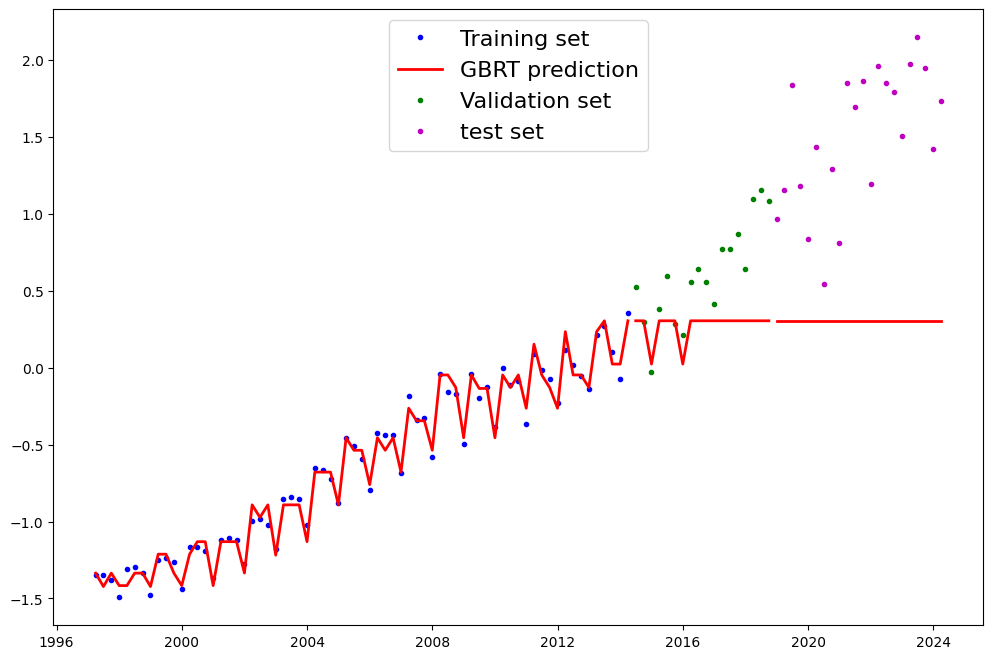

In [193]:
plt.figure(figsize=(12,8))

y_val_hb_pred_df = pd.Series(y_val_hb_pred, index= y_hb_val.index)
y_train_hb_pred_df = pd.Series(y_train_hb_pred, index= y_hb_train.index)
y_test_hb_pred = tuned_GBRT_hb.predict(X_hb_test.values)
y_test_hb_pred_df = pd.Series(y_test_hb_pred, index= y_hb_test.index)


plt.plot( y_hb_train, "b.", label="Training set")
plt.plot(y_train_hb_pred_df, "r-", linewidth=2, label="GBRT prediction")

plt.plot( y_hb_val, "g.", label="Validation set")
plt.plot(y_val_hb_pred_df, "r-", linewidth=2, )

plt.plot( y_hb_test, "m.", label="test set")
plt.legend(loc="upper center", fontsize=16)
plt.plot(y_test_hb_pred_df, "r-", linewidth=2,)
plt.show()

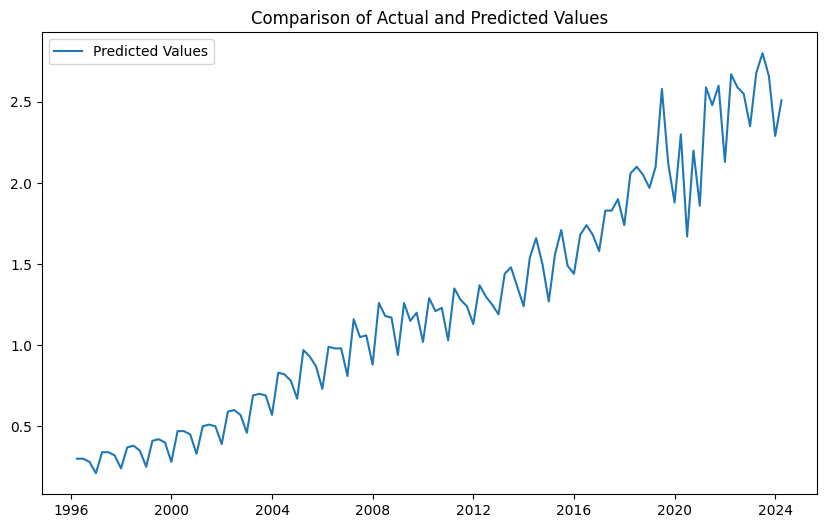

In [195]:
# Plotting
predicted_values = tuned_GBRT_hb.predict(X_hb_test.values)
predicted_values
plt.figure(figsize=(10, 6))
#plt.plot(y_hb_test.values, label='True Values')
plt.plot(Features_And_Target_df['Reported EPS'], label='Predicted Values')
plt.title('Comparison of Actual and Predicted Values')
plt.legend()
plt.show()

## Fitted Model and Results
    - Report on hyper parameters
    - Report on fit quality
    - Ideas on improvement if the model was continued to be

# Random Forest (Bhavesh)
## Why this model for this problem
## Model Architecture
## Model Specific Preprocessing 
## Model Specific Tuning
## Model Evaluation

## Fitted Model and Results
    - Report on hyper parameters
    - Report on fit quality
    - Ideas on improvement if the model was continued to be

# Kmeans Regimes + Markov Chain (Kevin)
## Why this model for this problem
## Model Architecture
## Model Specific Preprocessing 
## Model Specific Tuning
## Model Evaluation

## Fitted Model and Results
    - Report on hyper parameters
    - Report on fit quality
    - Ideas on improvement if the model was continued to be

# Appendix
Material used in the creation of the report, but not necessary to run the final report

## Helper functions

### Data retrieval and cleanup helper functions

## Helper functions

### Data retrieval and cleanup helper functions

## Helper functions

### Data retrieval and cleanup helper functions

In [7]:

def DeleteEmptyCSVs(CSVToCheck):
    # Function to delete any csvs that were created by an attempted data retrieval
    # but are empty of data
    if os.path.isfile(CSVToCheck):
        # Count the number of lines in the file
        with open(CSVToCheck, 'r') as file:
            reader = csv.reader(file)
            line_count = sum(1 for row in reader)
        
        print(f"The file {CSVToCheck} has {line_count} lines.")

        # Check if the line count is less 3 (header and empty line)
        if line_count < 3:
            print(f"{CSVToCheck} seems empty. Deleting the file.")
            os.remove(CSVToCheck)
        else:
            print(f"{CSVToCheck} seems to have data.")
    else:
        print(f"{CSVToCheck} does not exist.")

In [143]:
def getYahoo(tckr, tckr_csv):
    
    if not os.path.isfile(tckr_csv):
        print("Retrieving "+tckr+" Data from Yahoo...")
        try:
            tckr_data = yf.download(tckr, start=START_DATE_yahoo, end=END_DATE_yahoo)
            print("saving data to csv")
            tckr_data.to_csv(tckr_csv)
        except Exception as e:
            print(f"Failed to retrieve data: {e}")
    else:
        print(tckr+" data already saved in csv")



In [91]:
def getDividends(tckr):
    ticker = yf.Ticker(tckr)
    dividends_series = ticker.dividends
    csvFile = '.\data_files\\'
    csvFile = csvFile + tckr + 'dividends.csv'
    dividends_series.to_csv(csvFile)

In [75]:
def GetEarningsFromAlphaVantage(stock_ticker, data_folder = 'data_files'):
    # Request from API
    url = f'https://www.alphavantage.co/query?function=EARNINGS&symbol={stock_ticker}&apikey={AV_api_key}'
    response = requests.get(url)
    data = response.json()
    quarterly_file =  stock_ticker + 'quarterlyEarnings.csv'
    #annual_file =  stock_ticker + 'annualEarnings.csv'
    quarterly_csv = os.path.join(data_folder, quarterly_file)
    #annual_csv = os.path.join(data_folder, annual_file)
    # Parse the response to get EPS data and save it as a CSV file
    quarterly_earnings = data['quarterlyEarnings']
    #annual_earnings = data['annualEarnings']
    if not os.path.isfile(quarterly_csv):
        with open(quarterly_csv, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Fiscal Date','Estimated EPS', 'Reported EPS'])  # Write header row
            for earnings_data in quarterly_earnings:
                fiscal_date = earnings_data['fiscalDateEnding']
                estimated_eps = earnings_data['estimatedEPS']
                reported_eps = earnings_data['reportedEPS']
                writer.writerow([fiscal_date, estimated_eps, reported_eps])
    else:
        print("Quarterly Earnings CSV already present")
    # Report save
        
    print(f" Quarterly Earnings data saved to {quarterly_csv}")
    
    

In [73]:
def BalanceSheetFromAlphaVantage(stock_ticker, data_folder = 'data_files'):
    # Request from API
    url = 'https://www.alphavantage.co/query?function=BALANCE_SHEET&symbol=IBM&apikey=demo'
    response = requests.get(url)
    data = response.json()
    quarterly_file =  stock_ticker + 'quarterlyBalSheet.csv'
    #annual_file =  stock_ticker + 'annualEarnings.csv'
    quarterly_csv = os.path.join(data_folder, quarterly_file)
    #annual_csv = os.path.join(data_folder, annual_file)
    # Parse the response to get EPS data and save it as a CSV file
    quarterly_reports = data['quarterlyReports']
    #annual_earnings = data['annualEarnings']
    if not os.path.isfile(quarterly_csv):
        with open(quarterly_csv, mode='w', newline='') as file:
            writer = csv.writer(file)
            balance_sheet_items = list(quarterly_reports[0].keys())
            writer.writerow(balance_sheet_items)  # Write header row
            for report in quarterly_reports:
                curr_row = []
                for item in balance_sheet_items:
                    curr_row.append(report[item])
                writer.writerow(curr_row)
    else:
        print("Quarterly Earnings CSV already present")
    # Report save
        
    print(f" Quarterly Earnings data saved to {quarterly_csv}")
    
    

In [ ]:
#getYahoo(sp500_ticker, sp500_csv)

#getYahoo(vix_ticker,vix_csv)

#getYahoo(jj_ticker, jj_csv)

#getYahoo(micro_ticker,micro_csv)

#getDividends(jj_ticker)

#getDividends(micro_ticker)

#BalanceSheetFromAlphaVantage(stock_ticker=micro_ticker)
#GetEarningsFromAlphaVantage(stock_ticker= micro_ticker)

#BalanceSheetFromAlphaVantage(stock_ticker=jj_ticker)
#GetEarningsFromAlphaVantage(stock_ticker= jj_ticker)